In [2]:
!pip install rouge-score

  Using cached rouge_score-0.0.4-py2.py3-none-any.whl (22 kB)


In [49]:
from rouge_score import rouge_scorer
from rouge_score import scoring
import utils
import sentencepiece as spm
import numpy as np

In [22]:
CONTENT_KEY = 'inputs'
SUMMARY_KEY = 'targets'

In [15]:
sp = spm.SentencePieceProcessor(model_file="../pegasus/ckpt/pegasus_ckpt/c4.unigram.newline.10pct.96000.model")

In [13]:
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL", "rougeLsum"], use_stemmer=True)

In [62]:
def encodeSPTokens(example):
    return sp.encode(example)

def decodeStartingTokens(tokens, n):
    return sp.decode(tokens[:n])

def decodeEndTokens(tokens, n):
    if len(tokens) >= n:
        return sp.decode(tokens[(len(tokens)-n):])
    else:
        return sp.decode(tokens)

def decodeBookendTokens(tokens, n):
    if len(tokens) >= n:
        return decodeStartingTokens(tokens, n//2) + " " + decodeEndTokens(tokens, n//2)
    else:
        return sp.decode(tokens)

In [78]:
def evaluateBaselines(example, max_tokens, scorer, verbose=False):
    tokens = encodeSPTokens(example[CONTENT_KEY].numpy())
    start = decodeStartingTokens(tokens, max_tokens)
    end = decodeEndTokens(tokens, max_tokens)
    bookend = decodeBookendTokens(tokens, max_tokens)
    summary = example[SUMMARY_KEY].numpy()
    
    if verbose:
        print(f'starting {max_tokens} tokens: {start}')
        print(f'ending {max_tokens} tokens: {end}')
        print(f'bookend {max_tokens} tokens: {bookend}')
        print(f'reference summary: {summary}')
    
    scores = {
        'start': scorer.score(start, summary),
        'end': scorer.score(end, summary),
        'bookend': scorer.score(bookend, summary)
    }
    summary_length = len(encodeSPTokens(summary))
    content_length = len(tokens)
    return (scores, content_length, summary_length)

In [60]:
def getMidRecallScores(aggregate_scores):
    return {r: scores.mid.recall for r, scores in aggregate_scores.items()}

def getMidF1Scores(aggregate_scores):
    return {r: scores.mid.fmeasure for r, scores in aggregate_scores.items()}

def getMidPrecisionScores(aggregate_scores):
    return {r: scores.mid.precision for r, scores in aggregate_scores.items()}

In [79]:
subreddit_scores = {}
for i, subreddit in enumerate(utils.top50subreddits):
    print(i, "--", subreddit)
    key = 'eval'
    dataset = utils.build(f'subreddits_data/subreddit_{subreddit}_{key}.tfrecord', False)
    
    aggregate_scores = {
        'start': scoring.BootstrapAggregator(),
        'end': scoring.BootstrapAggregator(),
        'bookend': scoring.BootstrapAggregator()
    }
    content_lengths = []
    summary_lengths = []
    
    for i, example in enumerate(dataset.take(10000)):
        example_score, content_len, summary_len = evaluateBaselines(example, 128, scorer, verbose=(i==0))
        for key, score in example_score.items():
            aggregate_scores[key].add_scores(score)
        content_lengths.append(content_len)
        summary_lengths.append(summary_len)
        
    agg_scores = {k: v.aggregate() for k, v in aggregate_scores.items()}
    score_summary = {k: {'recall': getMidRecallScores(agg),
                         'precision': getMidPrecisionScores(agg),
                         'f1': getMidF1Scores(agg)}
                     for k, agg in agg_scores.items()}
    score_summary['avg_content_len'] = float(sum(content_lengths)) / len(content_lengths)
    score_summary['avg_summary_len'] = float(sum(summary_lengths)) / len(summary_lengths)
    print(score_summary)
    subreddit_scores[subreddit] = score_summary
    
    print('************\n')

0 -- AskReddit
starting 128 tokens: While, like many other people, I am afraid of needles, the reason I do not donate blood is not that simple. In fact, I was once willing to brave up to the needles and donate my blood; however, an unsavory experience with a blood drive that was administered left a taste in my mouth that was more dour and metallic than the blood that I was prepared to donate. I made it as far as what I believe is the penultimate step before I was denied: during the survey, when I was asked if I was either sick or had any ailment that would prevent me from donating blood, I volunteered information that, while relevant
ending 128 tokens: ist who has me undergo an endoscopy and a phlebotomy (first of three or four, don't remember exactly) and then renders a diagnosis--a diagnosis that would allow me to give blood; -During the survey, I mention the symptoms, the woman spoke on the phone with the supervising doctor, and proceeds to fill out a sheet of paper that says, effec

{'start': {'recall': {'rouge1': 0.0931650059562967, 'rouge2': 0.016892340598847883, 'rougeL': 0.05972839486055599, 'rougeLsum': 0.06227471320420372}, 'precision': {'rouge1': 0.4209578861645423, 'rouge2': 0.08440066114507774, 'rougeL': 0.29800676023844036, 'rougeLsum': 0.30259097509099986}, 'f1': {'rouge1': 0.13890891062161242, 'rouge2': 0.025675608717702275, 'rougeL': 0.0914772899750009, 'rougeLsum': 0.09437134331659275}}, 'end': {'recall': {'rouge1': 0.10051290354352971, 'rouge2': 0.02083939261083023, 'rougeL': 0.06463476076094796, 'rougeLsum': 0.06752015848718712}, 'precision': {'rouge1': 0.4498236004547457, 'rouge2': 0.09960678752725745, 'rougeL': 0.3167884388828679, 'rougeLsum': 0.32174035386282196}, 'f1': {'rouge1': 0.15014063284951923, 'rouge2': 0.03177766089326902, 'rougeL': 0.09893383069544812, 'rougeLsum': 0.10218473151698927}}, 'bookend': {'recall': {'rouge1': 0.09880112356496946, 'rouge2': 0.01936399298252999, 'rougeL': 0.06372446625275094, 'rougeLsum': 0.06673208372845435},

{'start': {'recall': {'rouge1': 0.09215944847985799, 'rouge2': 0.01735792723833403, 'rougeL': 0.060544843396969555, 'rougeLsum': 0.062259225148148495}, 'precision': {'rouge1': 0.4290473363755476, 'rouge2': 0.09149036905339594, 'rougeL': 0.31338212449898084, 'rougeLsum': 0.31625261340902094}, 'f1': {'rouge1': 0.13886545390698002, 'rouge2': 0.026730421022392377, 'rougeL': 0.09336444081622677, 'rougeLsum': 0.09532656710425139}}, 'end': {'recall': {'rouge1': 0.09153673466264842, 'rouge2': 0.016968345413736426, 'rougeL': 0.05965273859751884, 'rougeLsum': 0.06152191244842525}, 'precision': {'rouge1': 0.42475085773075916, 'rouge2': 0.0876875266554987, 'rougeL': 0.3078112462731137, 'rougeLsum': 0.310929315990947}, 'f1': {'rouge1': 0.13787317319306017, 'rouge2': 0.026121157069209686, 'rougeL': 0.09203699277961377, 'rougeLsum': 0.09415825826106691}}, 'bookend': {'recall': {'rouge1': 0.09394663460435626, 'rouge2': 0.01808367849126451, 'rougeL': 0.06165900460074579, 'rougeLsum': 0.0635245873721697

{'start': {'recall': {'rouge1': 0.07951962515171679, 'rouge2': 0.014844929951039663, 'rougeL': 0.05450173666905557, 'rougeLsum': 0.05555298107054739}, 'precision': {'rouge1': 0.4018867032068672, 'rouge2': 0.08343618869595193, 'rougeL': 0.303756565432457, 'rougeLsum': 0.3054102349523664}, 'f1': {'rouge1': 0.1218300530152098, 'rouge2': 0.023092687763707452, 'rougeL': 0.08518355365999944, 'rougeLsum': 0.08644382308731612}}, 'end': {'recall': {'rouge1': 0.08000857364396324, 'rouge2': 0.014735142989448505, 'rougeL': 0.054117184871350595, 'rougeLsum': 0.05530520216575419}, 'precision': {'rouge1': 0.4008700557751733, 'rouge2': 0.07996391803031368, 'rougeL': 0.2994941389218138, 'rougeLsum': 0.3015804063903029}, 'f1': {'rouge1': 0.12239178668347184, 'rouge2': 0.022878188949293228, 'rougeL': 0.08454956210289581, 'rougeLsum': 0.08590037566039731}}, 'bookend': {'recall': {'rouge1': 0.08106246217367762, 'rouge2': 0.015340331880265247, 'rougeL': 0.05522231861509613, 'rougeLsum': 0.05646594213676326}

{'start': {'recall': {'rouge1': 0.10660725930554316, 'rouge2': 0.02026967939734258, 'rougeL': 0.06599030769446294, 'rougeLsum': 0.06841311771412474}, 'precision': {'rouge1': 0.4333088362482157, 'rouge2': 0.09021756332816575, 'rougeL': 0.303505245842527, 'rougeLsum': 0.30746241751393566}, 'f1': {'rouge1': 0.15445511788830846, 'rouge2': 0.029812955957709136, 'rougeL': 0.09844446550107225, 'rougeLsum': 0.10107828094992188}}, 'end': {'recall': {'rouge1': 0.10958071960984338, 'rouge2': 0.021695576423345422, 'rougeL': 0.06734970836497473, 'rougeLsum': 0.06987136127134688}, 'precision': {'rouge1': 0.4435020991597224, 'rouge2': 0.09270623315338608, 'rougeL': 0.30781012899864224, 'rougeLsum': 0.3116123607886666}, 'f1': {'rouge1': 0.1586519212664212, 'rouge2': 0.03165858829694364, 'rougeL': 0.10030085699958566, 'rougeLsum': 0.10303471753960321}}, 'bookend': {'recall': {'rouge1': 0.11047579416363007, 'rouge2': 0.021671630697342507, 'rougeL': 0.0683122714576141, 'rougeLsum': 0.07103143551967822}, 

{'start': {'recall': {'rouge1': 0.0909557329877363, 'rouge2': 0.016816313668756105, 'rougeL': 0.06044645412610286, 'rougeLsum': 0.061939170826476236}, 'precision': {'rouge1': 0.4038095013637981, 'rouge2': 0.08350035581053589, 'rougeL': 0.2972636912028256, 'rougeLsum': 0.2996928418415673}, 'f1': {'rouge1': 0.13536484279760297, 'rouge2': 0.025492459863571494, 'rougeL': 0.09205054273877056, 'rougeLsum': 0.0936939711175924}}, 'end': {'recall': {'rouge1': 0.09069442405297594, 'rouge2': 0.016290069718822978, 'rougeL': 0.05928581237403449, 'rougeLsum': 0.06087054203290343}, 'precision': {'rouge1': 0.400568930588868, 'rouge2': 0.0789325122465151, 'rougeL': 0.2901797842615639, 'rougeLsum': 0.2930647137393374}, 'f1': {'rouge1': 0.13480349296230515, 'rouge2': 0.02463774305541004, 'rougeL': 0.09019880499826374, 'rougeLsum': 0.09191302794332089}}, 'bookend': {'recall': {'rouge1': 0.09262498080983217, 'rouge2': 0.017356902618198132, 'rougeL': 0.061167636178686244, 'rougeLsum': 0.06271871107947802}, 

{'start': {'recall': {'rouge1': 0.10164399545744716, 'rouge2': 0.017769088368912327, 'rougeL': 0.06453098233008611, 'rougeLsum': 0.06681652504267996}, 'precision': {'rouge1': 0.39118261390747316, 'rouge2': 0.07589293756154097, 'rougeL': 0.27701726066101484, 'rougeLsum': 0.2805334594244887}, 'f1': {'rouge1': 0.14666094771565577, 'rouge2': 0.02630971594350162, 'rougeL': 0.09560681788417835, 'rougeLsum': 0.09806267263641612}}, 'end': {'recall': {'rouge1': 0.10100101739479207, 'rouge2': 0.01700763400557576, 'rougeL': 0.0633952944700932, 'rougeLsum': 0.06555207296613813}, 'precision': {'rouge1': 0.3884113147892879, 'rouge2': 0.07161526500302344, 'rougeL': 0.27159549990756404, 'rougeLsum': 0.27483762231392544}, 'f1': {'rouge1': 0.14574538361082048, 'rouge2': 0.025098621462910708, 'rougeL': 0.09376917357036547, 'rougeLsum': 0.09623014471652158}}, 'bookend': {'recall': {'rouge1': 0.10237786395861098, 'rouge2': 0.01797204548327551, 'rougeL': 0.06494831197652844, 'rougeLsum': 0.06713865271322073

{'start': {'recall': {'rouge1': 0.08826419703465502, 'rouge2': 0.015860145383297955, 'rougeL': 0.05754603761242767, 'rougeLsum': 0.059079595369324674}, 'precision': {'rouge1': 0.4089440741136613, 'rouge2': 0.08306222883972081, 'rougeL': 0.3002936101612721, 'rougeLsum': 0.30273625960416173}, 'f1': {'rouge1': 0.13187217686991537, 'rouge2': 0.024354701291663144, 'rougeL': 0.08830241404750333, 'rougeLsum': 0.0900554520384372}}, 'end': {'recall': {'rouge1': 0.08773594294743452, 'rouge2': 0.015561163797425755, 'rougeL': 0.05691244540877142, 'rougeLsum': 0.058594427121698}, 'precision': {'rouge1': 0.40391641536391154, 'rouge2': 0.07979512874636868, 'rougeL': 0.29344564379983373, 'rougeLsum': 0.2964220480514056}, 'f1': {'rouge1': 0.1310964098286429, 'rouge2': 0.023774996771263254, 'rougeL': 0.08726343337047712, 'rougeLsum': 0.0891530881484811}}, 'bookend': {'recall': {'rouge1': 0.09013444076307725, 'rouge2': 0.01672143969335954, 'rougeL': 0.05855084591509725, 'rougeLsum': 0.06019919799152029},

{'start': {'recall': {'rouge1': 0.11065739962312501, 'rouge2': 0.01940818877358073, 'rougeL': 0.06767026762022083, 'rougeLsum': 0.0701456821348517}, 'precision': {'rouge1': 0.4204330666675199, 'rouge2': 0.07952335499564114, 'rougeL': 0.2912165285375491, 'rougeLsum': 0.2944292833167559}, 'f1': {'rouge1': 0.1575620535134436, 'rouge2': 0.02813822997607934, 'rougeL': 0.0995483788931042, 'rougeLsum': 0.10186569934181763}}, 'end': {'recall': {'rouge1': 0.11723322921987939, 'rouge2': 0.023470273086512228, 'rougeL': 0.07078669863328442, 'rougeLsum': 0.07333448446143846}, 'precision': {'rouge1': 0.44164206910420384, 'rouge2': 0.09552429314306832, 'rougeL': 0.2998562763136861, 'rougeLsum': 0.303748422429486}, 'f1': {'rouge1': 0.16730438001522602, 'rouge2': 0.03407474861016208, 'rougeL': 0.1039713704107271, 'rougeLsum': 0.10666513444833203}}, 'bookend': {'recall': {'rouge1': 0.11835261571951822, 'rouge2': 0.023374193445212313, 'rougeL': 0.07200176895446736, 'rougeLsum': 0.0748613678691888}, 'prec

{'start': {'recall': {'rouge1': 0.11510055554347459, 'rouge2': 0.02195840154104521, 'rougeL': 0.06963231340637754, 'rougeLsum': 0.07258469377842104}, 'precision': {'rouge1': 0.4443278542690574, 'rouge2': 0.09529612630438097, 'rougeL': 0.2980781200371243, 'rougeLsum': 0.30312110342074294}, 'f1': {'rouge1': 0.16699205391862101, 'rouge2': 0.03262239428484444, 'rougeL': 0.10350844452946728, 'rougeLsum': 0.10681359953197536}}, 'end': {'recall': {'rouge1': 0.11708572817626625, 'rouge2': 0.023392678525755765, 'rougeL': 0.07074197393563394, 'rougeLsum': 0.07408338646402561}, 'precision': {'rouge1': 0.4506610782635391, 'rouge2': 0.10032401025601186, 'rougeL': 0.30232671368290565, 'rougeLsum': 0.30710800698719576}, 'f1': {'rouge1': 0.1699319383586011, 'rouge2': 0.034965123572271536, 'rougeL': 0.10532997459137801, 'rougeLsum': 0.10896178450051991}}, 'bookend': {'recall': {'rouge1': 0.11744229603434256, 'rouge2': 0.023399489574078065, 'rougeL': 0.07149956353255796, 'rougeLsum': 0.07478322397397219

{'start': {'recall': {'rouge1': 0.10013913175256904, 'rouge2': 0.01846188993341485, 'rougeL': 0.06362493293016405, 'rougeLsum': 0.06601283752181514}, 'precision': {'rouge1': 0.44484572018871305, 'rouge2': 0.08996914935164571, 'rougeL': 0.3181146078472372, 'rougeLsum': 0.3221323978570303}, 'f1': {'rouge1': 0.14874195115527467, 'rouge2': 0.0279284354154277, 'rougeL': 0.0972282684418884, 'rougeLsum': 0.09996141737162573}}, 'end': {'recall': {'rouge1': 0.1003056808737354, 'rouge2': 0.018563310398812528, 'rougeL': 0.0627234492214479, 'rougeLsum': 0.06500429907970798}, 'precision': {'rouge1': 0.4383744360978943, 'rouge2': 0.08702131809217543, 'rougeL': 0.31019108039962273, 'rougeLsum': 0.31388723886417824}, 'f1': {'rouge1': 0.14860231054557516, 'rouge2': 0.027967743086399568, 'rougeL': 0.09567204823854111, 'rougeLsum': 0.09824958022797986}}, 'bookend': {'recall': {'rouge1': 0.10239781654458648, 'rouge2': 0.019598660063791476, 'rougeL': 0.06504413163559583, 'rougeLsum': 0.0672679204132163}, '

{'start': {'recall': {'rouge1': 0.13240383071975065, 'rouge2': 0.026645485259867846, 'rougeL': 0.08036784497031271, 'rougeLsum': 0.08321583291251419}, 'precision': {'rouge1': 0.4616855866022306, 'rouge2': 0.103975067386848, 'rougeL': 0.3081919486677833, 'rougeLsum': 0.31271547947888517}, 'f1': {'rouge1': 0.1878243462400324, 'rouge2': 0.03881171860547375, 'rougeL': 0.11702980833648373, 'rougeLsum': 0.12013256767501113}}, 'end': {'recall': {'rouge1': 0.14412274399951458, 'rouge2': 0.03509358538021583, 'rougeL': 0.08540037997690894, 'rougeLsum': 0.08873026590303448}, 'precision': {'rouge1': 0.4970945764638689, 'rouge2': 0.12813471327265868, 'rougeL': 0.32683202879765777, 'rougeLsum': 0.33102113881405637}, 'f1': {'rouge1': 0.2040277633285592, 'rouge2': 0.05059757168568454, 'rougeL': 0.1244611889984605, 'rougeLsum': 0.12791960567119204}}, 'bookend': {'recall': {'rouge1': 0.14239561879904128, 'rouge2': 0.033262197864781295, 'rougeL': 0.08683599373261182, 'rougeLsum': 0.09025399891889486}, 'p

{'start': {'recall': {'rouge1': 0.10373535357541118, 'rouge2': 0.018195159417293043, 'rougeL': 0.06539908423766788, 'rougeLsum': 0.06789800995351833}, 'precision': {'rouge1': 0.4075000050939943, 'rouge2': 0.08003139204943821, 'rougeL': 0.2885209592200193, 'rougeLsum': 0.2926492948444931}, 'f1': {'rouge1': 0.14950955179185466, 'rouge2': 0.02678112405748509, 'rougeL': 0.09674489101282538, 'rougeLsum': 0.0995627642503563}}, 'end': {'recall': {'rouge1': 0.10357668613714964, 'rouge2': 0.018116984094427878, 'rougeL': 0.06525202775724431, 'rougeLsum': 0.0675609564158057}, 'precision': {'rouge1': 0.404274462030561, 'rouge2': 0.07820607099702839, 'rougeL': 0.28562380487494443, 'rougeLsum': 0.2888525048635178}, 'f1': {'rouge1': 0.14919846314864574, 'rouge2': 0.026586512721235526, 'rougeL': 0.09652863285297617, 'rougeLsum': 0.09905501499950277}}, 'bookend': {'recall': {'rouge1': 0.1060603985985511, 'rouge2': 0.01880318810221556, 'rougeL': 0.06676378856245854, 'rougeLsum': 0.06922421894967018}, 'p

{'start': {'recall': {'rouge1': 0.10296750879656111, 'rouge2': 0.018293485062101947, 'rougeL': 0.06468242500623683, 'rougeLsum': 0.06755276363130838}, 'precision': {'rouge1': 0.4230568587296268, 'rouge2': 0.0876735675353222, 'rougeL': 0.3012721972696887, 'rougeLsum': 0.30649817665318346}, 'f1': {'rouge1': 0.1500602855551418, 'rouge2': 0.027524398098135772, 'rougeL': 0.09714629741537534, 'rougeLsum': 0.10053470785250482}}, 'end': {'recall': {'rouge1': 0.10215271844833124, 'rouge2': 0.017905875260757733, 'rougeL': 0.06400528756603688, 'rougeLsum': 0.06691483115488812}, 'precision': {'rouge1': 0.41926994471508594, 'rouge2': 0.08513476294118645, 'rougeL': 0.2975059722146841, 'rougeLsum': 0.30176733499673825}, 'f1': {'rouge1': 0.1488544086680602, 'rouge2': 0.026979839339279346, 'rougeL': 0.09614891360335281, 'rougeLsum': 0.0994712524416711}}, 'bookend': {'recall': {'rouge1': 0.10486377133804417, 'rouge2': 0.018910244864188255, 'rougeL': 0.06552803325372111, 'rougeLsum': 0.06830789996719466}

{'start': {'recall': {'rouge1': 0.09446446789818502, 'rouge2': 0.01767277584775829, 'rougeL': 0.06063465160390223, 'rougeLsum': 0.06268101339770915}, 'precision': {'rouge1': 0.42208843733630697, 'rouge2': 0.08656208392758706, 'rougeL': 0.29814080402872156, 'rougeLsum': 0.30171172075097685}, 'f1': {'rouge1': 0.14159478194402064, 'rouge2': 0.027152907201180392, 'rougeL': 0.09288512536532059, 'rougeLsum': 0.09515000699764395}}, 'end': {'recall': {'rouge1': 0.09673290492280842, 'rouge2': 0.01716330371712424, 'rougeL': 0.06061583011459411, 'rougeLsum': 0.06248006596033945}, 'precision': {'rouge1': 0.42948803478572595, 'rouge2': 0.08355352423868193, 'rougeL': 0.3000414497446922, 'rougeLsum': 0.30335798251680346}, 'f1': {'rouge1': 0.14460833469650705, 'rouge2': 0.026378332269695055, 'rougeL': 0.0929605666229899, 'rougeLsum': 0.09501639966456492}}, 'bookend': {'recall': {'rouge1': 0.09570148126152582, 'rouge2': 0.01755881995149315, 'rougeL': 0.06152969239913745, 'rougeLsum': 0.0636541040862494

{'start': {'recall': {'rouge1': 0.09197559311923362, 'rouge2': 0.017804746103449245, 'rougeL': 0.06009192312320066, 'rougeLsum': 0.06152578275921903}, 'precision': {'rouge1': 0.4301187517482273, 'rouge2': 0.09046671548368913, 'rougeL': 0.31515211508549024, 'rougeLsum': 0.3170280260060052}, 'f1': {'rouge1': 0.13759746021271704, 'rouge2': 0.027265040956612967, 'rougeL': 0.09231613833201938, 'rougeLsum': 0.09386509278584979}}, 'end': {'recall': {'rouge1': 0.09122804333845588, 'rouge2': 0.017057131697937107, 'rougeL': 0.05909328376651993, 'rougeLsum': 0.060617416524254494}, 'precision': {'rouge1': 0.4210640486042786, 'rouge2': 0.08483263585092568, 'rougeL': 0.3056441329653412, 'rougeLsum': 0.30783447218598636}, 'f1': {'rouge1': 0.13624783672187268, 'rouge2': 0.02609515608947907, 'rougeL': 0.09064620182812105, 'rougeLsum': 0.09239047746578219}}, 'bookend': {'recall': {'rouge1': 0.09309445598493593, 'rouge2': 0.017980811803772593, 'rougeL': 0.060932976880439305, 'rougeLsum': 0.06253820155757

{'start': {'recall': {'rouge1': 0.0958395166825526, 'rouge2': 0.015884357870898817, 'rougeL': 0.059492595681891844, 'rougeLsum': 0.06132786293638566}, 'precision': {'rouge1': 0.413754496199, 'rouge2': 0.07800087758418298, 'rougeL': 0.2909941120049089, 'rougeLsum': 0.2942790293278038}, 'f1': {'rouge1': 0.1404275881700887, 'rouge2': 0.02380980243441127, 'rougeL': 0.08985370742073193, 'rougeLsum': 0.09195217786560239}}, 'end': {'recall': {'rouge1': 0.09682165438231408, 'rouge2': 0.017411846891689627, 'rougeL': 0.06001307358122704, 'rougeLsum': 0.061804543454443375}, 'precision': {'rouge1': 0.4150520423862575, 'rouge2': 0.08211683363123776, 'rougeL': 0.28983706786643726, 'rougeLsum': 0.29337907513510275}, 'f1': {'rouge1': 0.1418549900706984, 'rouge2': 0.025963945527656733, 'rougeL': 0.09035469243987801, 'rougeLsum': 0.0924567189031647}}, 'bookend': {'recall': {'rouge1': 0.09856177420838966, 'rouge2': 0.017581224609823823, 'rougeL': 0.06093736456774651, 'rougeLsum': 0.06293076908498452}, 'p

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [76]:
temp_scores = subreddit_scores

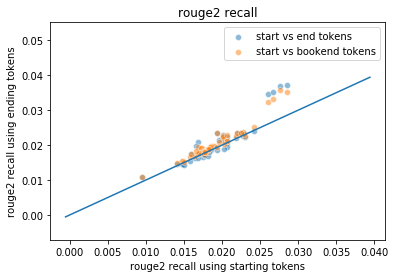

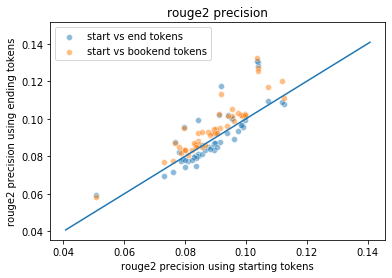

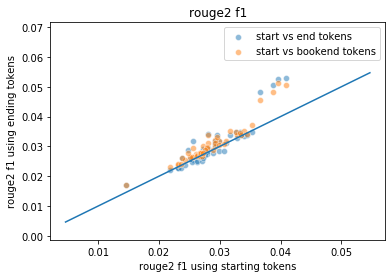

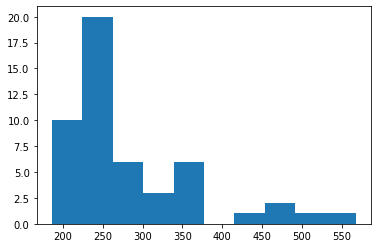

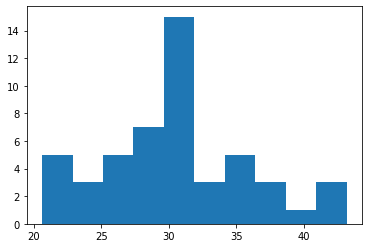

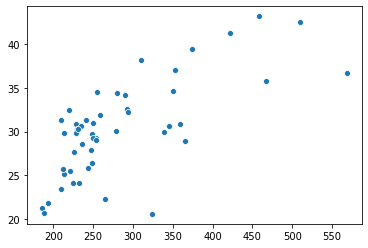

In [93]:
for r in ['rouge2']:
    for m in ['recall', 'precision', 'f1']:
        
        s = [score['start'][m][r] for sr, score in subreddit_scores.items()]
        e = [score['end'][m][r] for sr, score in subreddit_scores.items()]
        be = [score['bookend'][m][r] for sr, score in subreddit_scores.items()]
        sns.scatterplot(x=s, y=e, label='start vs end tokens', alpha=0.5)
        sns.scatterplot(x=s, y=be, label='start vs bookend tokens', alpha=0.5)
        
        plt.xlabel(f'{r} {m} using starting tokens')
        plt.ylabel(f'{r} {m} using ending tokens')
        identity = np.arange(min(min(s), min(e), min(be)) - 0.01, max(max(s), max(e), max(be)) + 0.01, 0.01)
        sns.lineplot(x=identity, y=identity)
        plt.title(f'{r} {m}')
        plt.legend()
        plt.show()
        
plt.hist([score['avg_content_len'] for sr, score in subreddit_scores.items()])
plt.show()
plt.hist([score['avg_sumamry_len'] for sr, score in subreddit_scores.items()])
plt.show()

sns.scatterplot([score['avg_content_len'] for sr, score in subreddit_scores.items()],
                [score['avg_sumamry_len'] for sr, score in subreddit_scores.items()])



In [94]:
[(sr, score) for sr, score in subreddit_scores.items() if score['bookend']['f1']['rouge2']>0.04]



[('relationships',
  {'start': {'recall': {'rouge1': 0.14048079018788134,
     'rouge2': 0.028534246456740745,
     'rougeL': 0.08336500209497157,
     'rougeLsum': 0.08642859630543152},
    'precision': {'rouge1': 0.4655475978527942,
     'rouge2': 0.1039478007225667,
     'rougeL': 0.3056096517694006,
     'rougeLsum': 0.309270742794336},
    'f1': {'rouge1': 0.19684132688751899,
     'rouge2': 0.04088259207015343,
     'rougeL': 0.12032469665730666,
     'rougeLsum': 0.12334752718465221}},
   'end': {'recall': {'rouge1': 0.15296759139014976,
     'rouge2': 0.037163433013218485,
     'rougeL': 0.0902226489881654,
     'rougeLsum': 0.09342494671681476},
    'precision': {'rouge1': 0.49868811890255293,
     'rouge2': 0.1303632231543164,
     'rougeL': 0.3238859362338148,
     'rougeLsum': 0.3279354552073678},
    'f1': {'rouge1': 0.21385742034654864,
     'rouge2': 0.05306049966725708,
     'rougeL': 0.12982476071484525,
     'rougeLsum': 0.13290232230143506}},
   'bookend': {'recall':

In [99]:
import tensorflow as tf
def write_tfrecord_file(dataset, filename):
    serialized_features_dataset = dataset.map(utils.tf_serialize_example)
    writer = tf.data.experimental.TFRecordWriter(filename)
    writer.write(serialized_features_dataset)

In [110]:

for i, subreddit in enumerate(utils.top50subreddits):
    print(i, "--", subreddit)
    for key in ['eval', 'test']:
        dataset = utils.build(f'subreddits_data/subreddit_{subreddit}_{key}.tfrecord', False)
        sub_r = dataset.take(100)
        filename = f'subreddits_data/subreddit_{subreddit}_{key}_100.tfrecord'
        writer = tf.data.experimental.TFRecordWriter(filename)
        write_tfrecord_file(sub_r, filename)

0 -- AskReddit
1 -- relationships
2 -- leagueoflegends
3 -- tifu
4 -- relationship_advice
5 -- trees
6 -- gaming
7 -- atheism
8 -- AdviceAnimals
9 -- funny
10 -- politics
11 -- pics
12 -- sex
13 -- WTF
14 -- explainlikeimfive
15 -- todayilearned
16 -- Fitness
17 -- IAmA
18 -- worldnews
19 -- DotA2
20 -- TwoXChromosomes
21 -- videos
22 -- DestinyTheGame
23 -- reddit.com
24 -- offmychest
25 -- buildapc
26 -- AskMen
27 -- personalfinance
28 -- summonerschool
29 -- technology
30 -- wow
31 -- NoFap
32 -- starcraft
33 -- dating_advice
34 -- askscience
35 -- Games
36 -- news
37 -- talesfromtechsupport
38 -- depression
39 -- pcmasterrace
40 -- Guildwars2
41 -- magicTCG
42 -- loseit
43 -- GlobalOffensive
44 -- electronic_cigarette
45 -- movies
46 -- self
47 -- Advice
48 -- Drugs
49 -- teenagers
